In [2]:
import scipy
import bagpy
import numpy as np
from bagpy import bagreader
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
from matplotlib import rc
import statistics
rc('text', usetex=False) 


In [3]:
bag = "median_filtered_data.bag"
bag = "first_box_touching_experiment.bag"
bag = "occlusion_exp.bag"
#bag = "unfiltered_data.bag"

b = bagreader(bag)

[INFO]  Successfully created the data folder occlusion_exp.


In [11]:
def get_topics(b):
    csv_files = []
    for topic in b.topics:
        #print(topic)
        data = b.message_by_topic(topic)
        csv_files.append(data)
    return csv_files

csv_files = get_topics(b)
print(csv_files
     )


upper_body_3d = pd.read_csv(csv_files[-1])
right_arm = pd.read_csv(csv_files[-2])
left_arm = pd.read_csv(csv_files[-3])
cart_right_arm = pd.read_csv(csv_files[1])

cart_left_arm = pd.read_csv(csv_files[0])
norm_left_arm = pd.read_csv(csv_files[4])


print(norm_left_arm)

['occlusion_exp/cart_left_arm.csv', 'occlusion_exp/cart_right_arm.csv', 'occlusion_exp/kalman_cart_right_arm.csv', 'occlusion_exp/left_arm.csv', 'occlusion_exp/norm_left_arm.csv', 'occlusion_exp/norm_right_arm.csv', 'occlusion_exp/right_arm.csv', 'occlusion_exp/upper_body_3d.csv']
             Time  header.seq  header.stamp.secs  header.stamp.nsecs  \
0    1.676638e+09           1         1676638250           178808927   
1    1.676638e+09           2         1676638250           218760013   
2    1.676638e+09           3         1676638250           258680105   
3    1.676638e+09           4         1676638250           298702001   
4    1.676638e+09           5         1676638250           338324069   
..            ...         ...                ...                 ...   
617  1.676638e+09         618         1676638274           858964920   
618  1.676638e+09         619         1676638274           898740053   
619  1.676638e+09         620         1676638274           938631057  

In [18]:
csv_files = get_topics(b)

print(csv_files)

def scale_any_time(time):    
    scaled_time = pd.Series([t - time[0] for t in time])    
    return scaled_time

def plot_arm(arm, savename, title="left_arm"): 
    
        
    w, h = 10, 5
    
    plt.figure(figsize=(w, h))
    
    scaled_t = scale_any_time(arm["Time"])
    s_pitch = arm["shoulder_pitch.data"]
    s_roll = arm["shoulder_roll.data"]
    s_yaw = arm["shoulder_yaw.data"]
    e = arm["elbow.data"]

    
    plt.plot(scaled_t, s_pitch, label="s_pitch", linewidth=2)
    #plt.plot(jst, m_pitch, label="m_pitch")
    plt.plot(scaled_t, s_roll, label="s_roll", linewidth=2)
    #plt.plot(jst, m_roll, label="m_roll")
    plt.plot(scaled_t, s_yaw, label="s_yaw", linewidth=2)
    #plt.plot(jst, m_yaw, label="m_yaw")
    plt.plot(scaled_t, e, label="elbow", linewidth=2)
    #plt.plot(jst, m_e, label="elbow")
    
    plt.grid(color="grey")
    plt.title("{}".format(title), fontsize=20)
    plt.xlabel("Time [s]", fontsize=15)
    plt.ylabel("Angle [rad]", fontsize=15)
    plt.legend(loc='best', fontsize=12)
    plt.tight_layout()
    plt.savefig(savename)
    
def plot_position(arm, savename, title): 
    
    w, h = 10, 5
    
    plt.figure(figsize=(w, h))
    t = scale_any_time(arm["Time"])
    
    x = arm["positionEE.x"]
    y = arm["positionEE.y"]
    z = arm["positionEE.z"]

    plt.plot(t, x, label="x")
    plt.plot(t, y, label="y")
    plt.plot(t, z, label="z")
    plt.grid(color="grey")
    plt.title(title, fontsize=20)
    plt.xlabel("Time[s]", fontsize=15)
    plt.ylabel("position [m]", fontsize=15)
    plt.legend(loc="best", fontsize=15)
    plt.tight_layout()
    plt.savefig(savename)
    
def plot_norms(norm, savename, title):
    
    w, h = 10, 5
    
    plt.figure(figsize=(w, h))
    t = scale_any_time(norm["Time"])
    
    sE = norm["shoulderElbow.data"]
    eW = norm["elbowWrist.data"]
    sW = norm["shoulderWrist.data"]

    plt.plot(t, sE, label="sE")
    plt.plot(t, eW, label="eW")
    plt.plot(t, sW, label="sW")
    plt.grid(color="grey")
    plt.title(title, fontsize=20)
    plt.xlabel("Time[s]", fontsize=15)
    plt.ylabel("norm [m]", fontsize=15)
    plt.legend(loc="best", fontsize=15)
    plt.tight_layout()
    plt.savefig(savename)
    
    
    

['occlusion_exp/cart_left_arm.csv', 'occlusion_exp/cart_right_arm.csv', 'occlusion_exp/kalman_cart_right_arm.csv', 'occlusion_exp/left_arm.csv', 'occlusion_exp/norm_left_arm.csv', 'occlusion_exp/norm_right_arm.csv', 'occlusion_exp/right_arm.csv', 'occlusion_exp/upper_body_3d.csv']


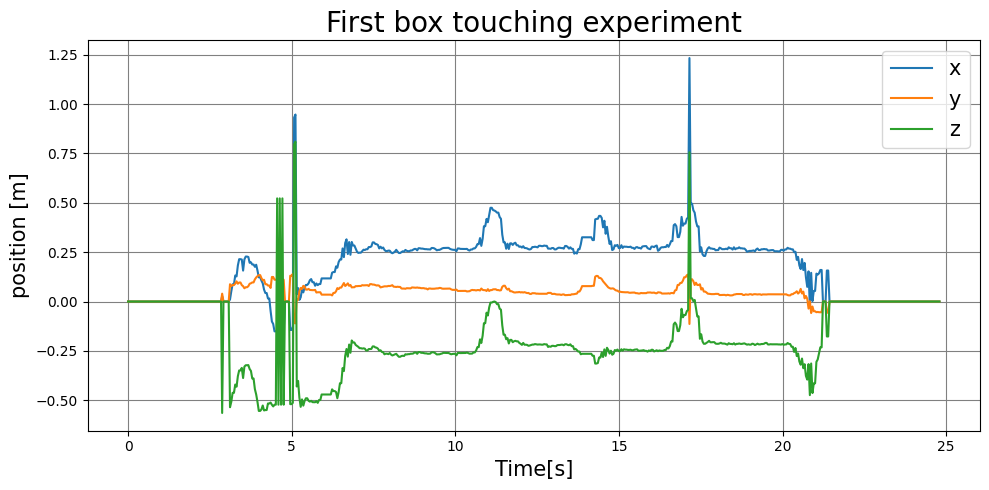

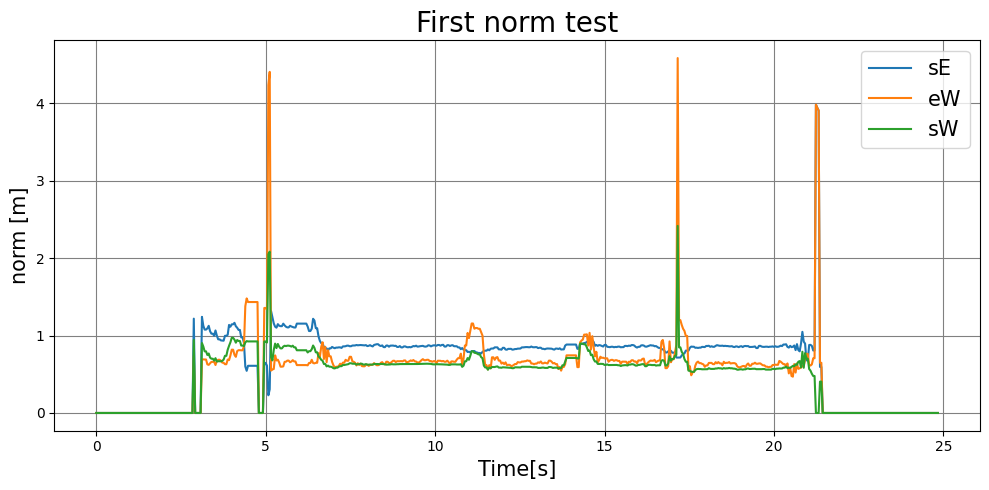

In [19]:
plot_position(cart_left_arm, "Box touching", "First box touching experiment")
plot_norms(norm_left_arm, "Norm", "First norm test")

In [263]:
import time
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

total_len  = len(cart_left_arm['Time'])
start = 0
end = total_len
t = scale_any_time(cart_left_arm['Time']).tolist()[start:end]
t = [t_*0.04 for t_ in t]
px = cart_left_arm['positionEE.x'].tolist()[start:end] 
py = cart_left_arm['positionEE.y'].tolist()[start:end] 
pz = cart_left_arm['positionEE.z'].tolist()[start:end] 
vx = cart_left_arm['velocityEE.x'].tolist()[start:end]
vy = cart_left_arm['velocityEE.y'].tolist()[start:end]
vz = cart_left_arm['velocityEE.z'].tolist()[start:end]

m_val = 27
median_px = scipy.signal.medfilt(np.array(px), m_val)
median_py = scipy.signal.medfilt(np.array(py), m_val)
median_pz = scipy.signal.medfilt(np.array(pz), m_val)


In [264]:
def getNextMeas(array, n):
    return array[n]

# Kalman filter 

Used resources are: 
 * [Vehicle location estimation](https://www.kalmanfilter.net/multiExamples.html) 
 

In [265]:
numMeas = len(px)
print("Num meas is: {}".format(numMeas))
kalmanX, kalmanY, kalmanZ = [], [], []
kalmanvX, kalmanvY, kalmanvZ = [], [], []
x_start = px[0]
vx_start = 0
y_start = py[0]
vy_start = 0
z_start = pz[0]
vz_start = 0

f = KalmanFilter (dim_x=6, dim_z=3)

# position vector
f.x = np.array([[x_start],
                [vx_start], 
                [y_start], 
                [vy_start], 
                [z_start], 
                [vz_start]])

# State transition 
f.F = np.array([[1., 0.04, 0., 0.00, 0., 0.00], 
                [0., 1.00, 0., 0.00, 0., 0.00], 
                [0., 0.00, 1., 0.04, 0., 0.00], 
                [0., 0.00, 0., 1.00, 0., 0.00], 
                [0., 0.00, 0., 0.00, 1., 0.04],
                [0., 0.00, 0., 0.00, 0., 1.00]])

f.P = np.array([[1., 0., 0., 0., 0., 0.], 
                [0., 1., 0., 0., 0., 0.], 
                [0., 0., 1., 0., 0., 0.], 
                [0., 0., 0., 1., 0., 0.], 
                [0., 0., 0., 0., 1., 0.],
                [0., 0., 0., 0., 0., 1.]])

f.R = np.eye(3)*500
f.H = np.array([[1., 0., 0., 0., 0., 0.], 
                [0., 0., 1., 0., 0., 0.], 
                [0., 0., 0., 0., 1., 0.]])

k = 10
f.Q = np.array([[k, 0., 0., 0., 0., 0.], 
                [0., k/10, 0., 0., 0., 0.], 
                [0., 0., k, 0., 0., 0.], 
                [0., 0., 0., k/10, 0., 0.], 
                [0., 0., 0., 0., k, 0.], 
                [0, 0., 0., 0., 0., k/10]])




for i in range(0, numMeas):
    xn = getNextMeas(px, i)
    yn = getNextMeas(py, i)
    zn = getNextMeas(pz, i)
    f.predict()
    f.update(np.array([xn, yn, zn]))
    kalmanX.append(f.x[0])
    kalmanvX.append(f.x[1])
    kalmanY.append(f.x[2])
    kalmanvY.append(f.x[3])
    kalmanZ.append(f.x[4])
    kalmanvZ.append(f.x[5])


Num meas is: 9754


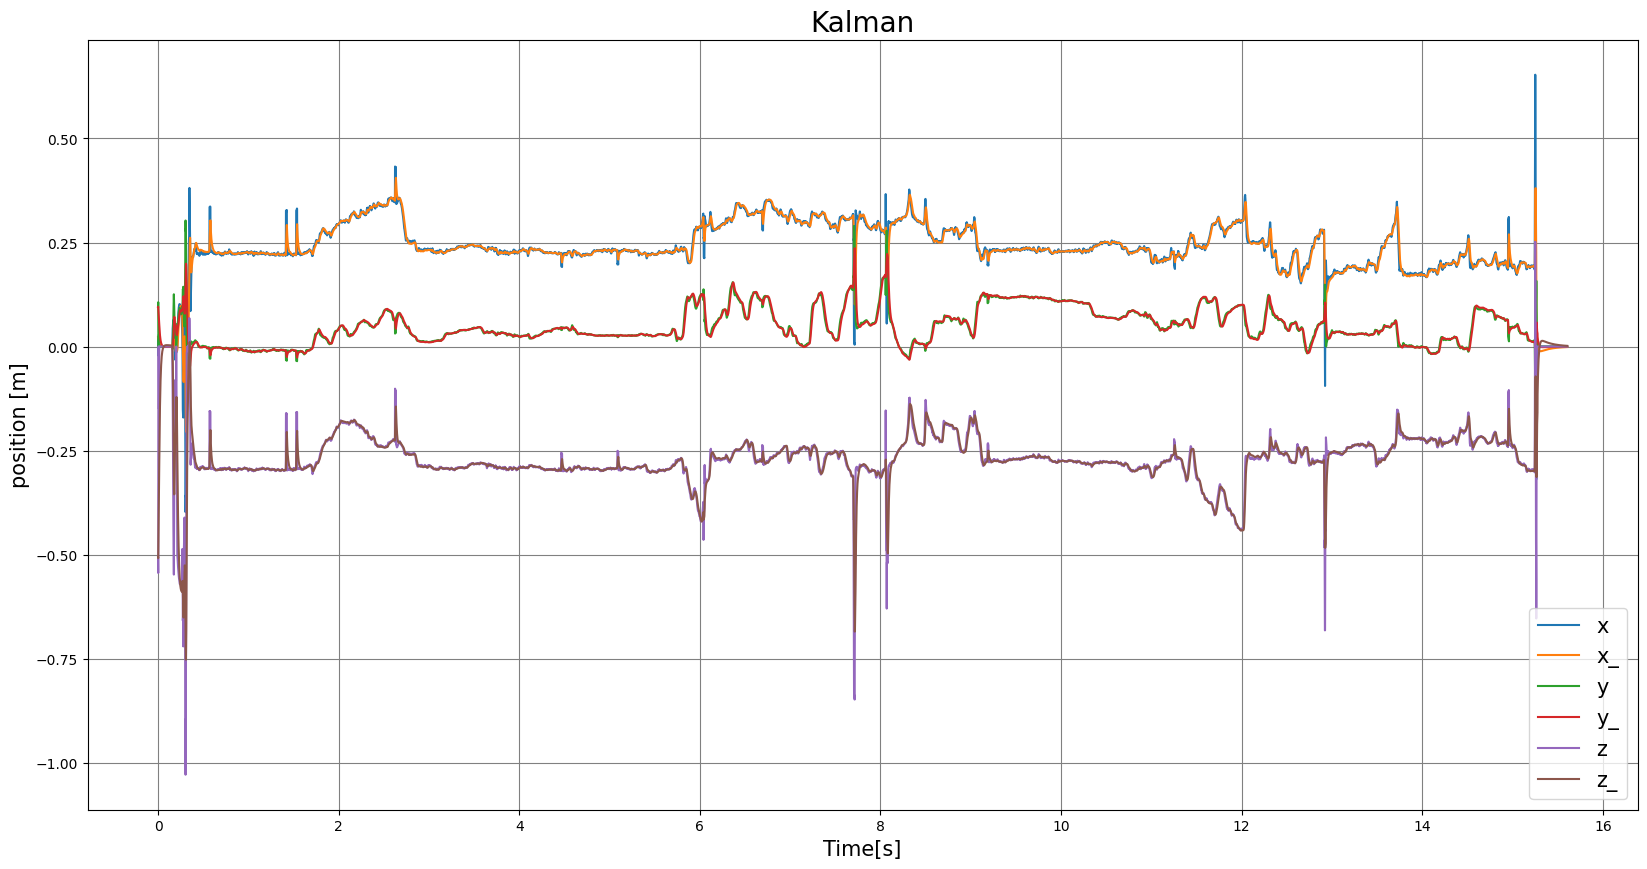

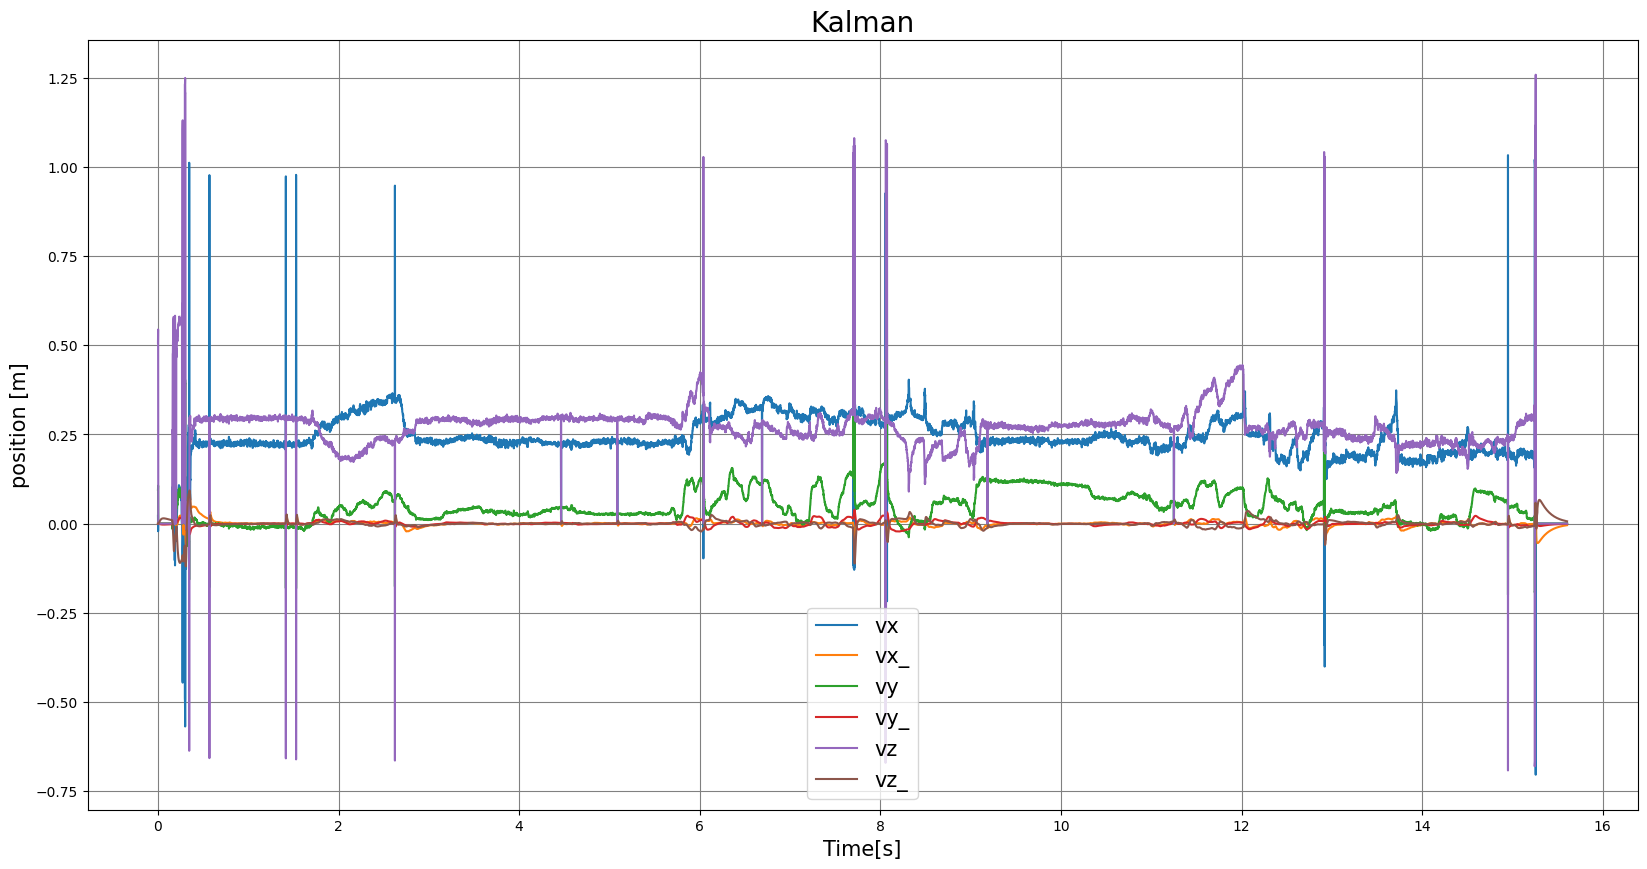

In [266]:
x_ = kalmanX
vx_ = kalmanvX
y_ = kalmanY
vy_ = kalmanvY
z_ = kalmanZ
vz_ = kalmanvZ

w, h = 20, 10    
plt.figure(figsize=(w, h))
plt.plot(t, px, label="x")
plt.plot(t, x_, label="x_")
plt.plot(t, py, label="y")
plt.plot(t, y_, label="y_")
plt.plot(t, pz, label="z")
plt.plot(t, z_, label="z_")
plt.grid(color="grey")
plt.title("Kalman", fontsize=20)
plt.xlabel("Time[s]", fontsize=15)
plt.ylabel("position [m]", fontsize=15)
plt.legend(loc="best", fontsize=15)

w, h = 20, 10    
plt.figure(figsize=(w, h))
plt.plot(t, vx, label="vx")
plt.plot(t, vx_, label="vx_")
plt.plot(t, vy, label="vy")
plt.plot(t, vy_, label="vy_")
plt.plot(t, vz, label="vz")
plt.plot(t, vz_, label="vz_")
plt.grid(color="grey")
plt.title("Kalman", fontsize=20)
plt.xlabel("Time[s]", fontsize=15)
plt.ylabel("position [m]", fontsize=15)
plt.legend(loc="best", fontsize=15)



In [267]:
print(axs)

[<Axes: > <Axes: > <Axes: >]


In [268]:
numMeas = len(px)
print("Num meas is: {}".format(numMeas))
kalmanX, kalmanY, kalmanZ = [], [], []
kalmanvX, kalmanvY, kalmanvZ = [], [], []
x_start = median_px[0]
vx_start = 0
y_start = median_py[0]
vy_start = 0
z_start = median_pz[0]
vz_start = 0

f = KalmanFilter (dim_x=6, dim_z=3)

# position vector
f.x = np.array([[x_start],
                [vx_start], 
                [y_start], 
                [vy_start], 
                [z_start], 
                [vz_start]])

# State transition 
f.F = np.array([[1., 0.04, 0., 0.00, 0., 0.00], 
                [0., 1.00, 0., 0.00, 0., 0.00], 
                [0., 0.00, 1., 0.04, 0., 0.00], 
                [0., 0.00, 0., 1.00, 0., 0.00], 
                [0., 0.00, 0., 0.00, 1., 0.04],
                [0., 0.00, 0., 0.00, 0., 1.00]])

f.P = np.array([[1., 0., 0., 0., 0., 0.], 
                [0., 1., 0., 0., 0., 0.], 
                [0., 0., 1., 0., 0., 0.], 
                [0., 0., 0., 1., 0., 0.], 
                [0., 0., 0., 0., 1., 0.],
                [0., 0., 0., 0., 0., 1.]])

f.R = np.eye(3)*50
f.H = np.array([[1., 0., 0., 0., 0., 0.], 
                [0., 0., 1., 0., 0., 0.], 
                [0., 0., 0., 0., 1., 0.]])

f.Q = np.array([[5., 0., 0., 0., 0., 0.], 
                [0., 0.4, 0., 0., 0., 0.], 
                [0., 0., 5., 0., 0., 0.], 
                [0., 0., 0., 0.4, 0., 0.], 
                [0., 0., 0., 0., 5.0, 0.], 
                [0, 0., 0., 0., 0., 0.4]])




for i in range(0, numMeas):
    xn = getNextMeas(median_px, i)
    yn = getNextMeas(median_py, i)
    zn = getNextMeas(median_pz, i)
    f.predict()
    f.update(np.array([xn, yn, zn]))
    kalmanX.append(f.x[0])
    kalmanvX.append(f.x[1])
    kalmanY.append(f.x[2])
    kalmanvY.append(f.x[3])
    kalmanZ.append(f.x[4])
    kalmanvZ.append(f.x[5])

Num meas is: 9754


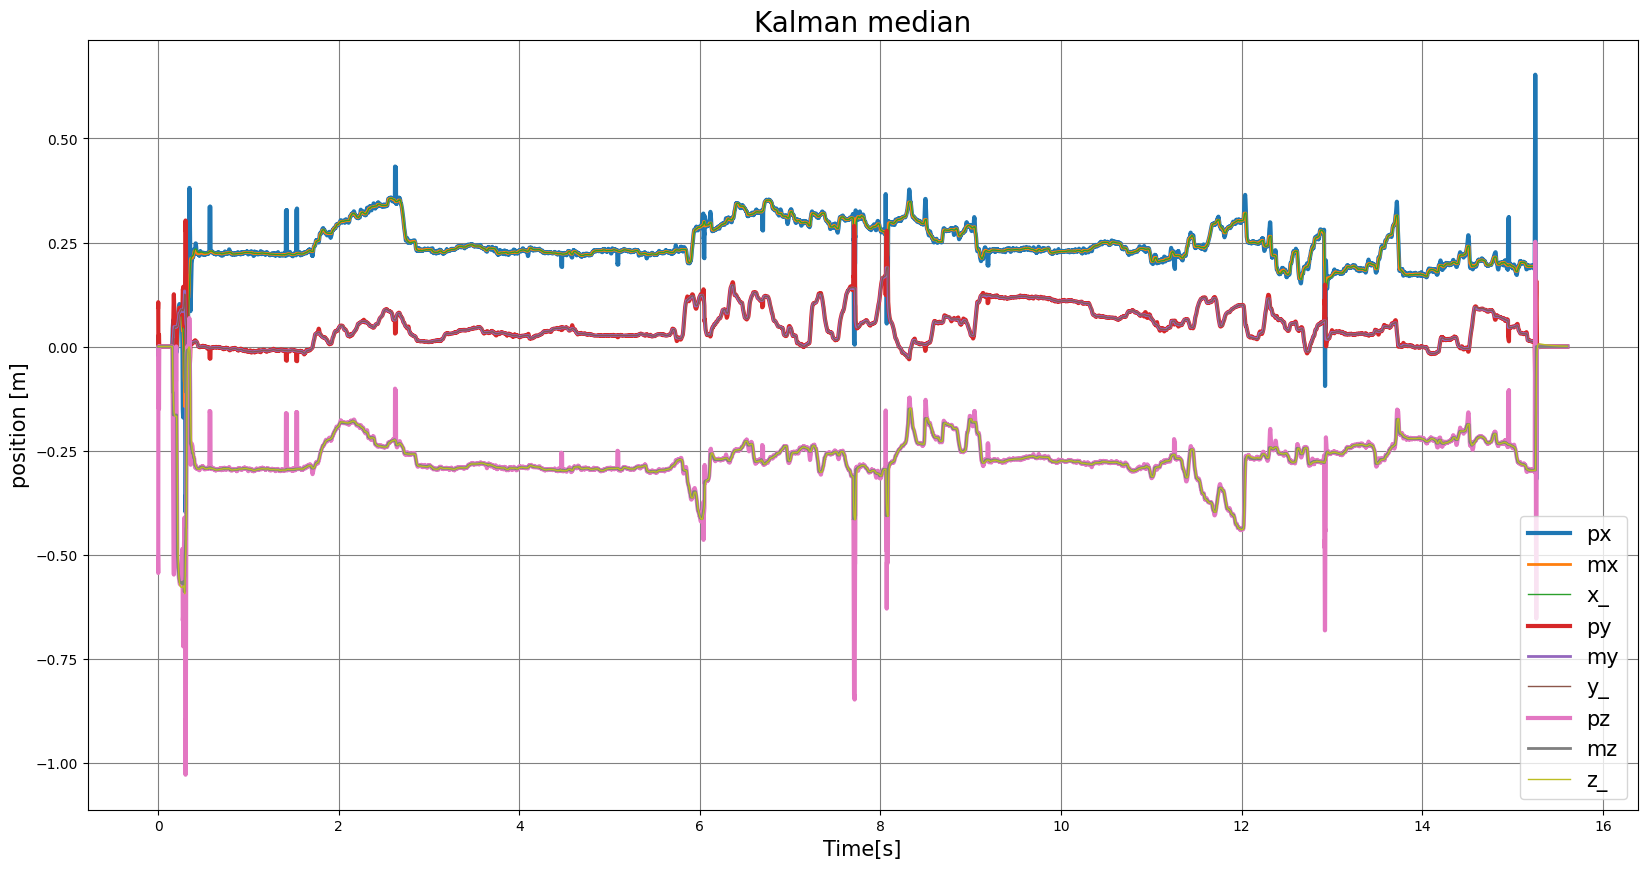

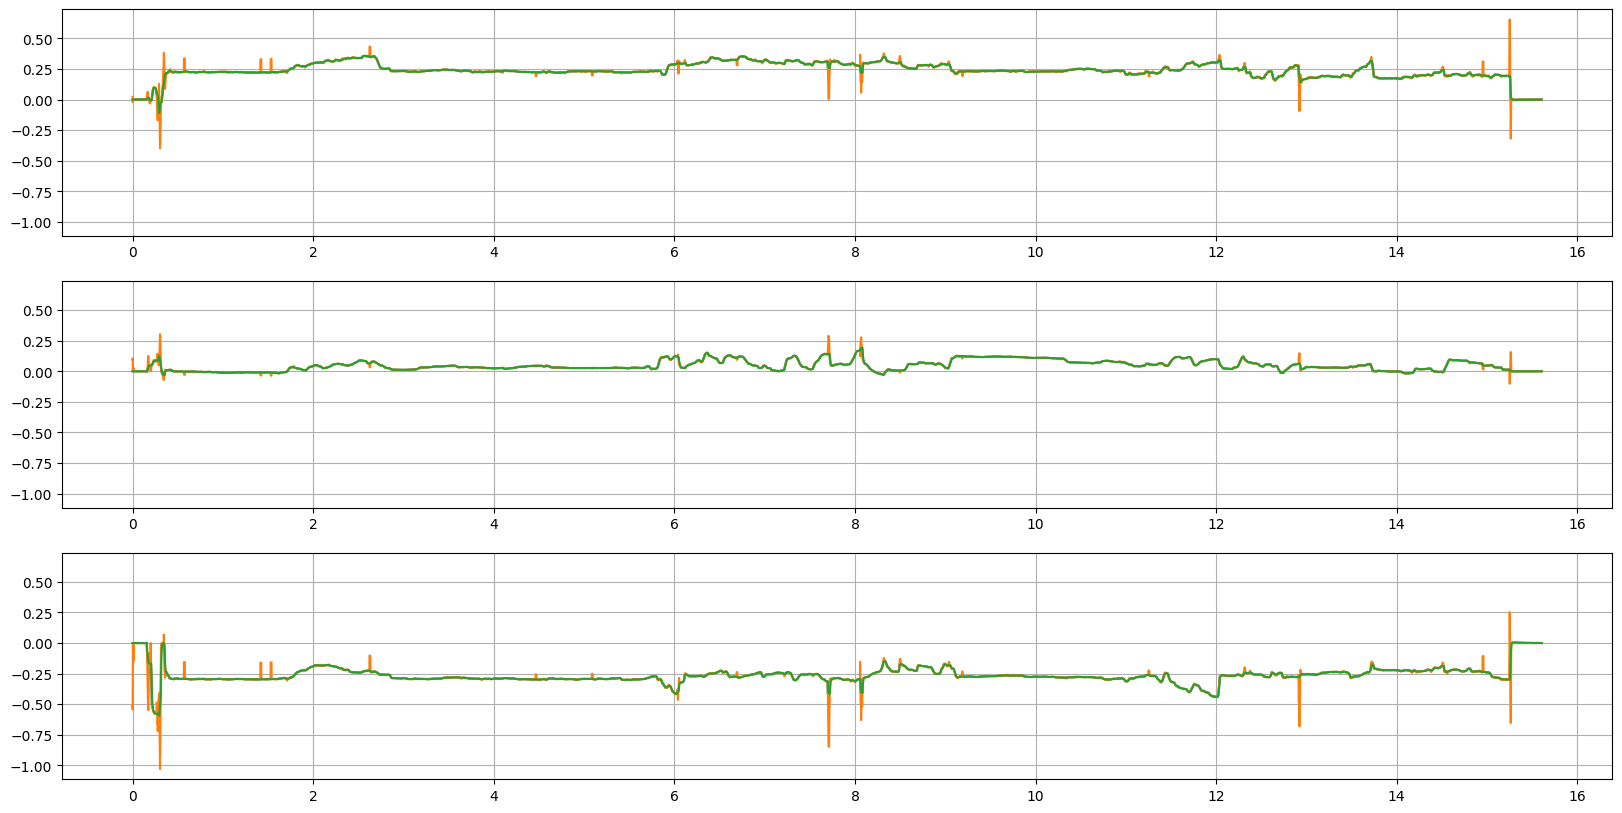

In [269]:
x_ = kalmanX
vx_ = kalmanvX
y_ = kalmanY
vy_ = kalmanvY
z_ = kalmanZ
vz_ = kalmanvZ

w, h = 20, 10    
plt.figure(figsize=(w, h))
l_ = 3
ml_ = 2
kl_ = 1
plt.plot(t, px, label="px", linewidth=l_)
plt.plot(t, median_px, label="mx", linewidth=ml_)
plt.plot(t, x_, label="x_", linewidth=kl_)
plt.plot(t, py, label="py", linewidth=l_)
plt.plot(t, median_py, label="my", linewidth=ml_)
plt.plot(t, y_, label="y_", linewidth=kl_)
plt.plot(t, pz, label="pz", linewidth=l_)
plt.plot(t, median_pz, label="mz", linewidth=ml_)
plt.plot(t, z_, label="z_", linewidth=kl_)
plt.grid(color="grey")
plt.title("Kalman median", fontsize=20)
plt.xlabel("Time[s]", fontsize=15)
plt.ylabel("position [m]", fontsize=15)
plt.legend(loc="best", fontsize=15)


f, axs = plt.subplots(3, 1, sharey=True, figsize=(20, 10))
axs[0].plot(t, median_px, label="mx")
axs[0].plot(t, px, label="px")
axs[0].plot(t, x_, label="x_")
#axs[0].set_ylim(np.min(px), np.max(px))
axs[0].grid()
axs[1].plot(t, median_py, label="my")
axs[1].plot(t, py, label="y")
axs[1].plot(t, y_, label="y_")
#axs[1].set_ylim(np.min(py), np.max(py))
axs[1].grid()
axs[2].plot(t, median_pz, label="my")
axs[2].plot(t, pz, label="z")
axs[2].plot(t, z_, label="z_")
#axs[2].set_ylim(np.min(pz), np.max(pz))
axs[2].grid()